# Exercises

## Exercise 1: explore filter parameters
---
In this exercises you will explore how different parameters affect the filtering process.
- Import the data form `data/moving_lfp.pickle` (the file is already on your machine if you run the `download_data()` cell in the main lesson)
- Take a few seconds of the data, and filter them in different frequency bands. Plot the resulting signal.
  Fix the central frequency and play with the width of the band, then try to change the central frequency of the band.
- Change the order of the filter, keeping the frequency band fixed. How does the filtered signal change? How does the computing time change? (You can try to quantify the computing time with the jupyter magic command [`%timeit`](https://docs.python.org/3/library/timeit.html) )
       


In [5]:
"""
DOCSTRING
"""

from pywt import scale2frequency
from pywt import cwt
from scipy.signal import butter
from scipy.signal import sosfilt
import numpy as np


def bandpass_filter(signal, low_f, high_f, sampling_rate=1.0, filter_order=5):
    '''
    Band pass filter based on the scipy implementation of butterwirth filtering.

    Returns the filtered signal in the specified frequency band.

    Parameters
    ----------
    signal : array-like
        the signal to filter

    low_f : float
        lower bound of the frequency band

    high_f : float
        higher bound of the frequency band

    sampling_rate : float
        sampling rate of the signal, defaults to 1 if not specified

    filter_order : int
        order of the butterwirth filter, defaults to 15 if not specified

    Returns
    -------
    filtered_signal : array-like
        filtered signal

    '''
    filter = butter(filter_order, [low_f, high_f],
                    btype='band', output='sos', fs=sampling_rate)
    filtered_signal = sosfilt(filter, signal)
    return filtered_signal


def morlet_transform(signal, low_f, high_f, n_freqs=20, sampling_rate=1.0):
    """
    Morlet transforms the signal in a given frequency band, with given frequency resolution

    Parameters
    ---------------------
    signal

    low_f

    high_f

    n_freqs

    sampling_rate

    Returns
    ---------------------
    C:
    freq:
    """
    frequencies = np.linspace(low_f, high_f, n_freqs)/sampling_rate
    scales = scale2frequency('cmor1-0.5', frequencies)
    C, freq = cwt(signal, wavelet='cmor1-0.5', scales=scales,
                  sampling_period=1.0/sampling_rate)
    return C, freq


def power(signal, low_f, high_f, sampling_rate=1.0, n_freqs=20):
    '''
    '''
    C, freq = morlet_transform(
        signal, low_f, high_f, sampling_rate=sampling_rate, n_freqs=n_freqs)
    power = np.mean(abs(C), axis=0)
    return power

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
import sys
import os
sys.path.append(os.path.abspath("code/"))

import lfp_functions as lf

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False,
                     'image.cmap':plt.cm.jet})

In [19]:
with open('moving_lfp.pickle', 'rb') as handle:
    lfp_data = pickle.load(handle)

lfp = lfp_data['lfp']
sampling_rate = lfp_data['sampling_rate']
print(f'Loaded {len(lfp)/sampling_rate} seconds of LFP, sampled at {sampling_rate} Hz')

Loaded 600.133 seconds of LFP, sampled at 1000.0 Hz


Text(0, 0.5, 'voltage (mV)')

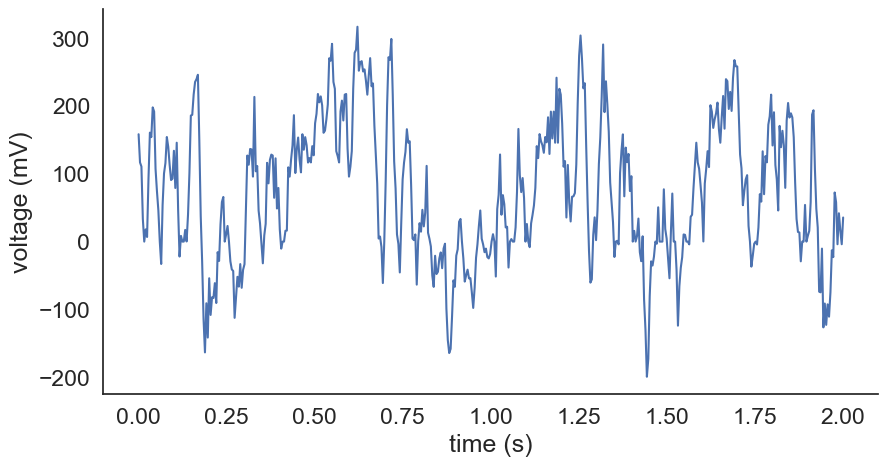

In [14]:

plt.figure(figsize=(10,5))
plt.plot(np.linspace(0,2,500),lfp[1000:1500])
plt.xlabel('time (s)')
plt.ylabel('voltage (mV)')


Text(0, 0.5, 'voltage (mV)')

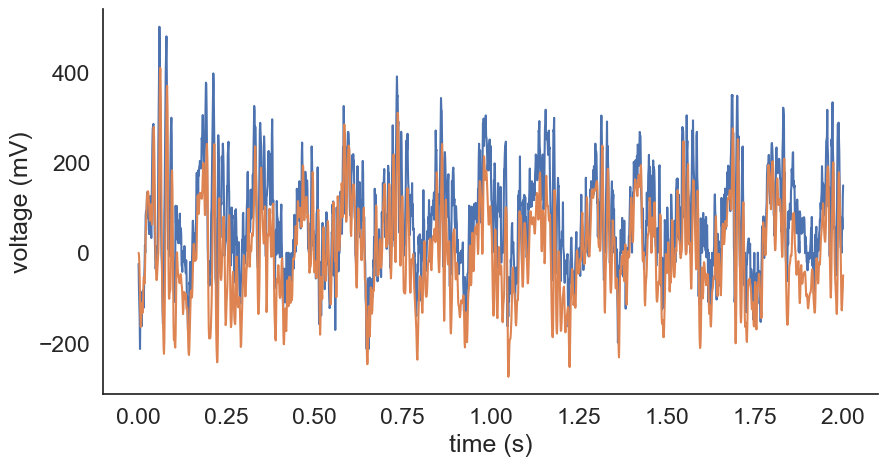

In [25]:
#%%timeit

from scipy.signal import butter
from scipy.signal import sosfilt

filter_order = 5 #the higher the order, the sharper the filter frequency response, 
                 #but with more computations and potental numerical instability
low_f = 1
high_f = 200

#define filter object
filter = butter(filter_order,[low_f,high_f],
                btype='band', 
                output='sos', 
                fs=sampling_rate)
                
#apply filter to lfp       
wideband_lfp = sosfilt(filter, lfp)

plt.figure(figsize=(10,5))
plt.plot(np.linspace(0,2,2000),lfp[:2000],label='raw signal') 
plt.plot(np.linspace(0,2,2000),wideband_lfp[:2000],label = 'wideband filtered')
plt.xlabel('time (s)')
plt.ylabel('voltage (mV)')

Text(0, 0.5, 'voltage (mV)')

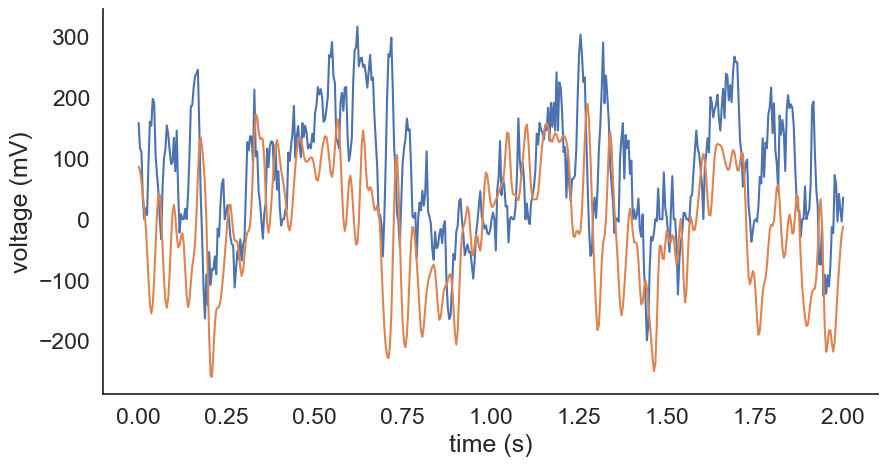

In [27]:
#%%timeit

from scipy.signal import butter
from scipy.signal import sosfilt


filter_order = 10 #higher  order, more sharp  filter frequency response, 
                 #but with more computations and potental numerical instability
                #Higher computing time

low_f = 1
high_f = 200

#define filter object
filter = butter(filter_order,[low_f,high_f],
                btype='band', 
                output='sos', 
                fs=sampling_rate)
                
#apply filter to lfp       
wideband_lfp = sosfilt(filter, lfp)

plt.figure(figsize=(10,5))
plt.plot(np.linspace(0,2,500),lfp[1000:1500],label='raw signal') #adjusted the width of the frequency band to 500 instead of 2000
plt.plot(np.linspace(0,2,500),wideband_lfp[1000:1500],label = 'wideband filtered')
plt.xlabel('time (s)')
plt.ylabel('voltage (mV)')

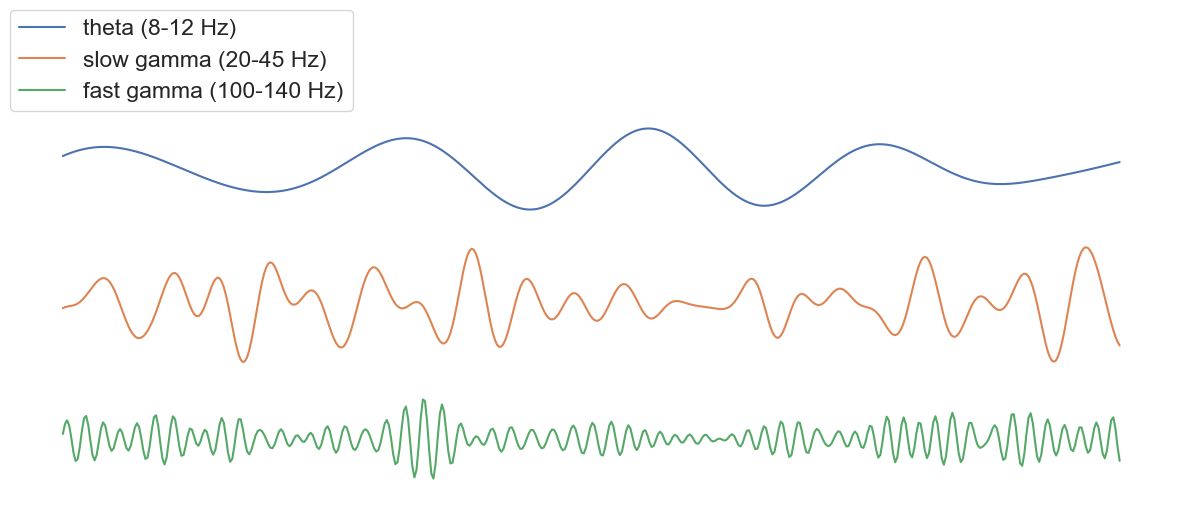

In [21]:
#%%timeit

theta_lfp = lf.bandpass_filter(lfp,low_f=8,high_f=12, sampling_rate=sampling_rate)
slow_gamma_lfp = lf.bandpass_filter(lfp,low_f=20,high_f=45, sampling_rate=sampling_rate)
fast_gamma_lfp = lf.bandpass_filter(lfp,low_f=100,high_f=140, sampling_rate=sampling_rate)

plot_offset = 200 #to plot the signal on different lines

plt.figure(figsize=(15,5))
plt.plot(theta_lfp[1000:1500]+2*plot_offset,label='theta (8-12 Hz)')
plt.plot(slow_gamma_lfp[1000:1500]+plot_offset,label = 'slow gamma (20-45 Hz)')
plt.plot(fast_gamma_lfp[1000:1500],label = 'fast gamma (100-140 Hz)')

plt.axis('off')
plt.legend(loc=(0,1))


 When you change the central frequency of the band, different parts of the signal are emphasized or attenuated. For example, if you shift the central frequency towards lower frequencies, you'll look at the more low-frequency components of the signal and vice-versa. When changing the width of the frequency band, its selectivity changes. I changed the width of the frequency band from 2000 to 500, and this narrower bandwidth resulted in a more selective filter, emphasizing only a narrow range of frequencies around the central frequency and it then also filters out unwanted frequencies. However, if you would make the bandwith too narrow, it can create an overshoot in the filtered signal. On the other hand, a wider bandwidth would allow a broader range of frequencies to pass through the filter.
  When increasing the filter order, it results in sharper frequency response and better attenuation in the stopbands. However, higher-order filters also introduce more phase distortion, which can affect the temporal characteristics of the filtered signal. 
  It's essential to have a balance between filter selectivity and computational complexity. Higher-order filters offer better selectivity but at the cost of increased computation time and potential artifacts in the filtered signal. When I changed the filter order from 5 to 10, making it a higher-order filter, the computing time became longer. 
